## This notebook is used to investigate the QSO redshift error problem

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from getdist import plots
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike.samplers.emcee import EmceeSampler
from desilike.samples import plotting, Chain
from desilike import setup_logging
setup_logging()  # for logging messages

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [37]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, PLANCK_COSMOLOGY, COLOR_TRACERS
from fit_cubic_tools import get_observable_likelihood, load_bins, load_mock_cov, load_cubic_sys_fns
%load_ext autoreload
%autoreload 2

Z_VSMEAR = REDSHIFT_LSS_VSMEAR
Z_CUBIC = REDSHIFT_LSS_CUBICBOX
result_dir = '/pscratch/sd/s/shengyu/results/cubic'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
fit = 'FM' # FM: Full-Modeling, SF: Shape-Fit
task = f'{fit}fit_cubic_sys'
theory_model = 'vel' # vel, folps
cov_type = 'EZcov_fn' # EZcov_fn, EZcov_fn_rsf
corr_type = 'pk'
bins_type = 'y3_sys'
tracer = 'QSO'

index = 0
(zmin, zmax) = Z_VSMEAR[tracer][index]
z_eff = Z_CUBIC[tracer][index]
# if 'rsf' in cov_type:
#     emulator_fn = result_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov.npy'
# else:
#     emulator_fn = result_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}.npy'
# emulator_fn = result_dir+f'/emulator/extra/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov_fix_ns.npy'
# emulator_fn = result_dir+f'/emulator/extra/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov_dv_obs.npy'
emulator_fn = f'./QSO_test/emulator_QSO_norsf_standard.npy'

In [44]:
for sys_model in ['standard','dv-obs']:
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000"}
    # fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": cov_type, "theory_model": theory_model}
    fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": cov_type, "theory_model": theory_model, "emulator_fn": emulator_fn}
    (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
    # for param in likelihood.varied_params:
    #     print(param, param.prior)

    if not os.path.exists(emulator_fn):
        emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
        emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
        emulator.fit()
        emulator.save(emulator_fn)
    
    chain_fn = f'./QSO_test/chian_QSO_norsf_{sys_model}.npy'
    if not os.path.exists(chain_fn):
        nwalkers = 64
        iterations = 30001 # save every 300 iterations
        sampler = EmceeSampler(likelihood, seed=42, nwalkers=nwalkers, save_fn = chain_fn)
        sampler.run(check={'max_eigen_gr': 0.001}, max_iterations = iterations) # save every 300 iterations

Loading exist EZmocks covariance


Cov_fn: /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_QSO_z0.8-2.1_k0.02-0.2.txt
[000133.12] [0/1] 05-12 02:39  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph020/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/base.py:445: UserWarning: Derived parameter sigma8 of <desilike.theories.galaxy_clustering.full_shape.LPTVelocileptorsPowerSpectrumMultipoles object at 0x7f1a898953d0> is already derived in <desilike.theories.galaxy_clustering.power_template.DirectPowerSpectrumTemplate object at 0x7f1a8988d2b0>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000206.18] [0/1] 05-12 02:41  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[000253.31] [0/1] 05-12 02:41  Differentiation           INFO     h grid is [0.6136 0.6436 0.6736 0.7036 0.7336].
[000253.31] [0/1] 05-12 02:41  Differentiation           INFO     omega_cdm grid is [0.1  0.11 0.12 0.13 0.14].
[000253.31] [0/1] 05-12 02:41  Differentiation           INFO     omega_b grid is [0.01937 0.02087 0.02237 0.02387 0.02537].
[000253.31] [0/1] 05-12 02:41  Differentiation           INFO     logA grid is [2.89639426 2.96639426 3.03639426 3.10639426 3.17639426].
[000253.31] [0/1] 05-12 02:41  Differentiation           INFO     n_s grid is [0.9449 0.9549 0.9649 0.9749 0.9849].
[000253.32] [0/1] 05-12 02:41  Differentiation           INFO     Differentiation will evaluate 141 points.
[001953.20] [0/1] 05-12 03:10  Emulator                  INFO     Fitting sigma8.
[001953.27] [0/1] 05-12 03:10  Emulator                  INFO     Fitting p

[005466.30] [0/1] 05-12 04:08  Chain                     INFO     Loading ./QSO_test/chian_QSO_norsf_standard.npy.
[005466.41] [0/1] 05-12 04:08  Chain                     INFO     Loading ./QSO_test/chian_QSO_norsf_dv-obs.npy.
Removed no burn in
Removed no burn in


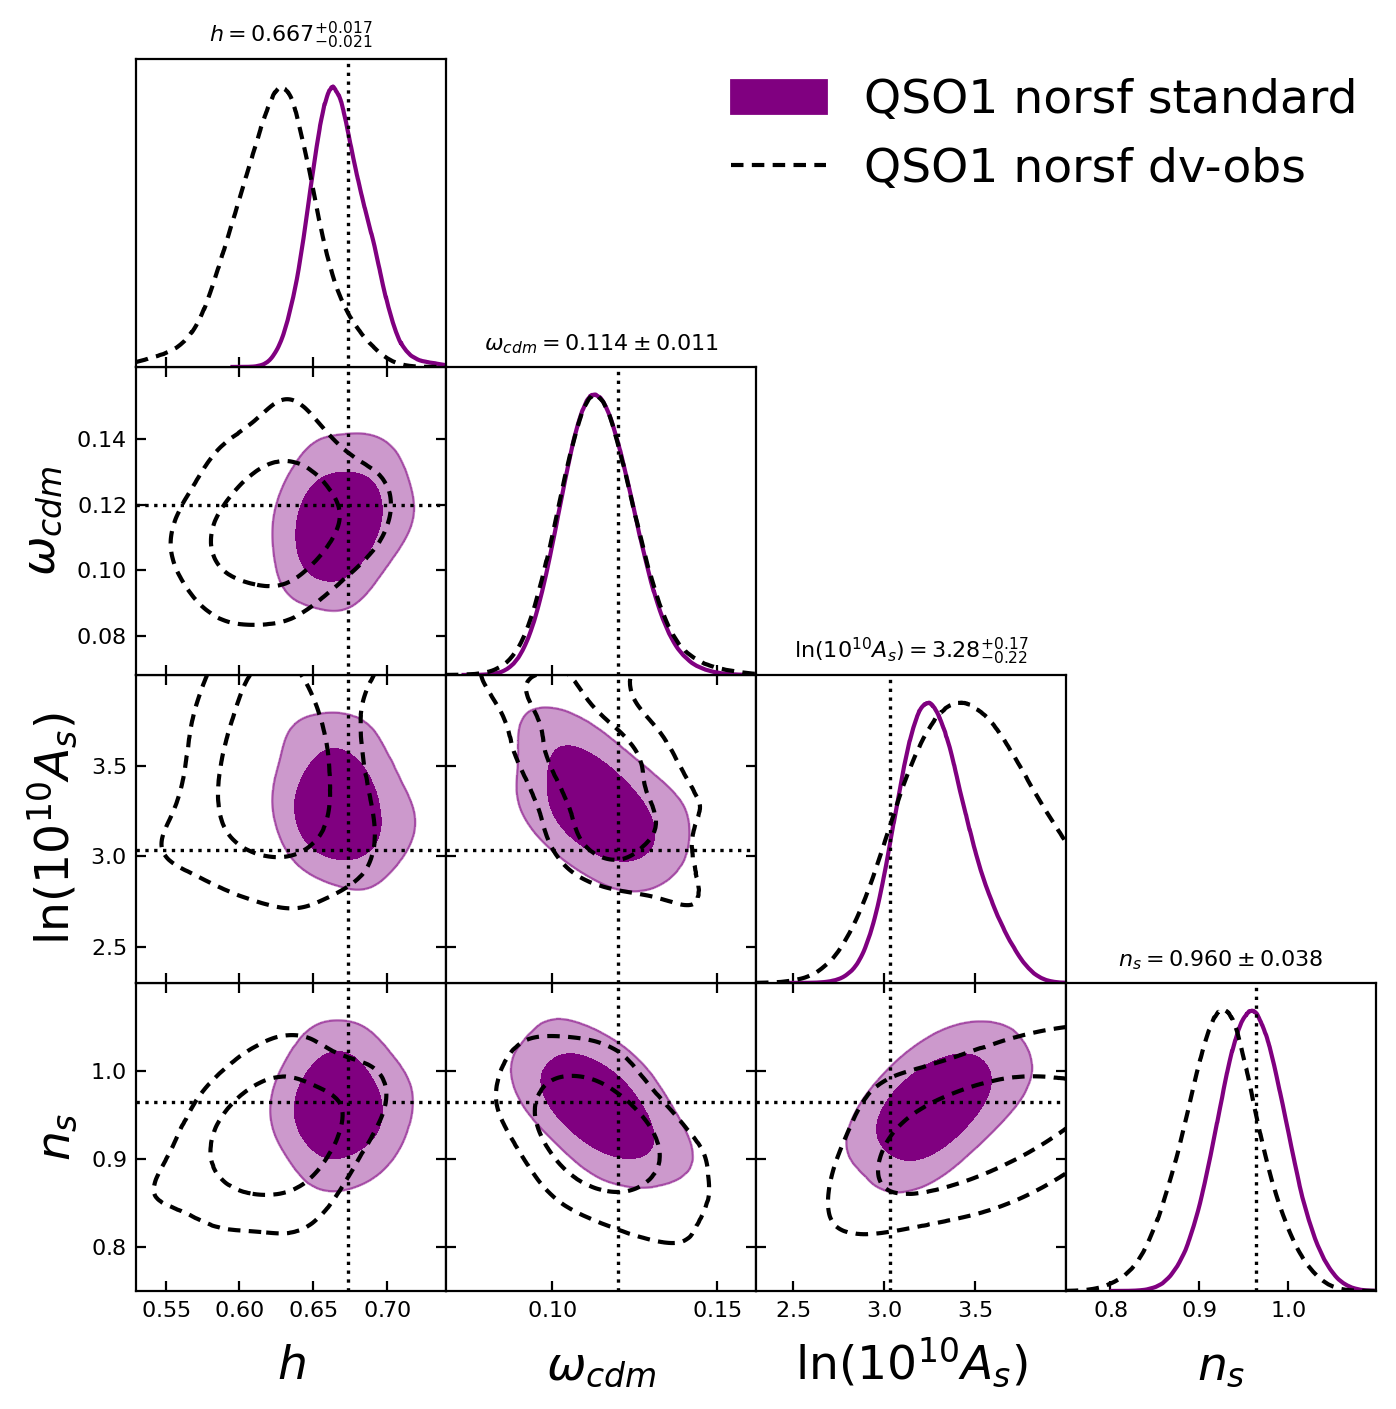

In [64]:
burnin = 0.5
slice_step = 4000

chains   = []
params = ['h', 'omega_cdm', 'logA','n_s']
for sys_model in ['standard','dv-obs']:
    chain_fn = f'./QSO_test/chian_QSO_norsf_{sys_model}.npy'
    chains.append(Chain.load(chain_fn).remove_burnin(burnin)[::slice_step])
# param_limits = {'h':[0.60,0.74],'omega_cdm':[0.083,0.152],'logA':[2.0,4.0], 'n_s':[0.8,1.1]}
param_limits = {'h':[0.53,0.74],'omega_cdm':[0.068,0.162],'logA':[2.3,4.0], 'n_s':[0.75,1.1]}


g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
# g.settings.fig_width_inch= 16
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.figure_legend_frame = False
labels  = [f'{tracer}1 norsf standard', f'{tracer}1 norsf dv-obs']
plotting.plot_triangle(chains, title_limit=1, filled = True, 
                       params = params,
                       legend_labels = labels, legend_loc= 'upper right',
                       contour_lws = 1.5, contour_colors = [COLOR_TRACERS['QSO'][0], 'black', 'grey'],contour_ls = ['-', '--', '--'],
                        param_limits=param_limits, 
                        smoothed=True, show=False, g=g)
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
true_values     = set_true_values(fit, params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)

Loading exist EZmocks covariance
Cov_fn: /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.8-1.1_k0.02-0.2.txt
[011529.53] [0/1] 05-12 05:49  Emulator                  INFO     Loading ./QSO_test/emulator_QSO_norsf_standard.npy.


[011529.68] [0/1] 05-12 05:49  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph020/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph012/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy].
Loading exist EZmocks covariance
Cov_fn: /pscratch/sd/s/

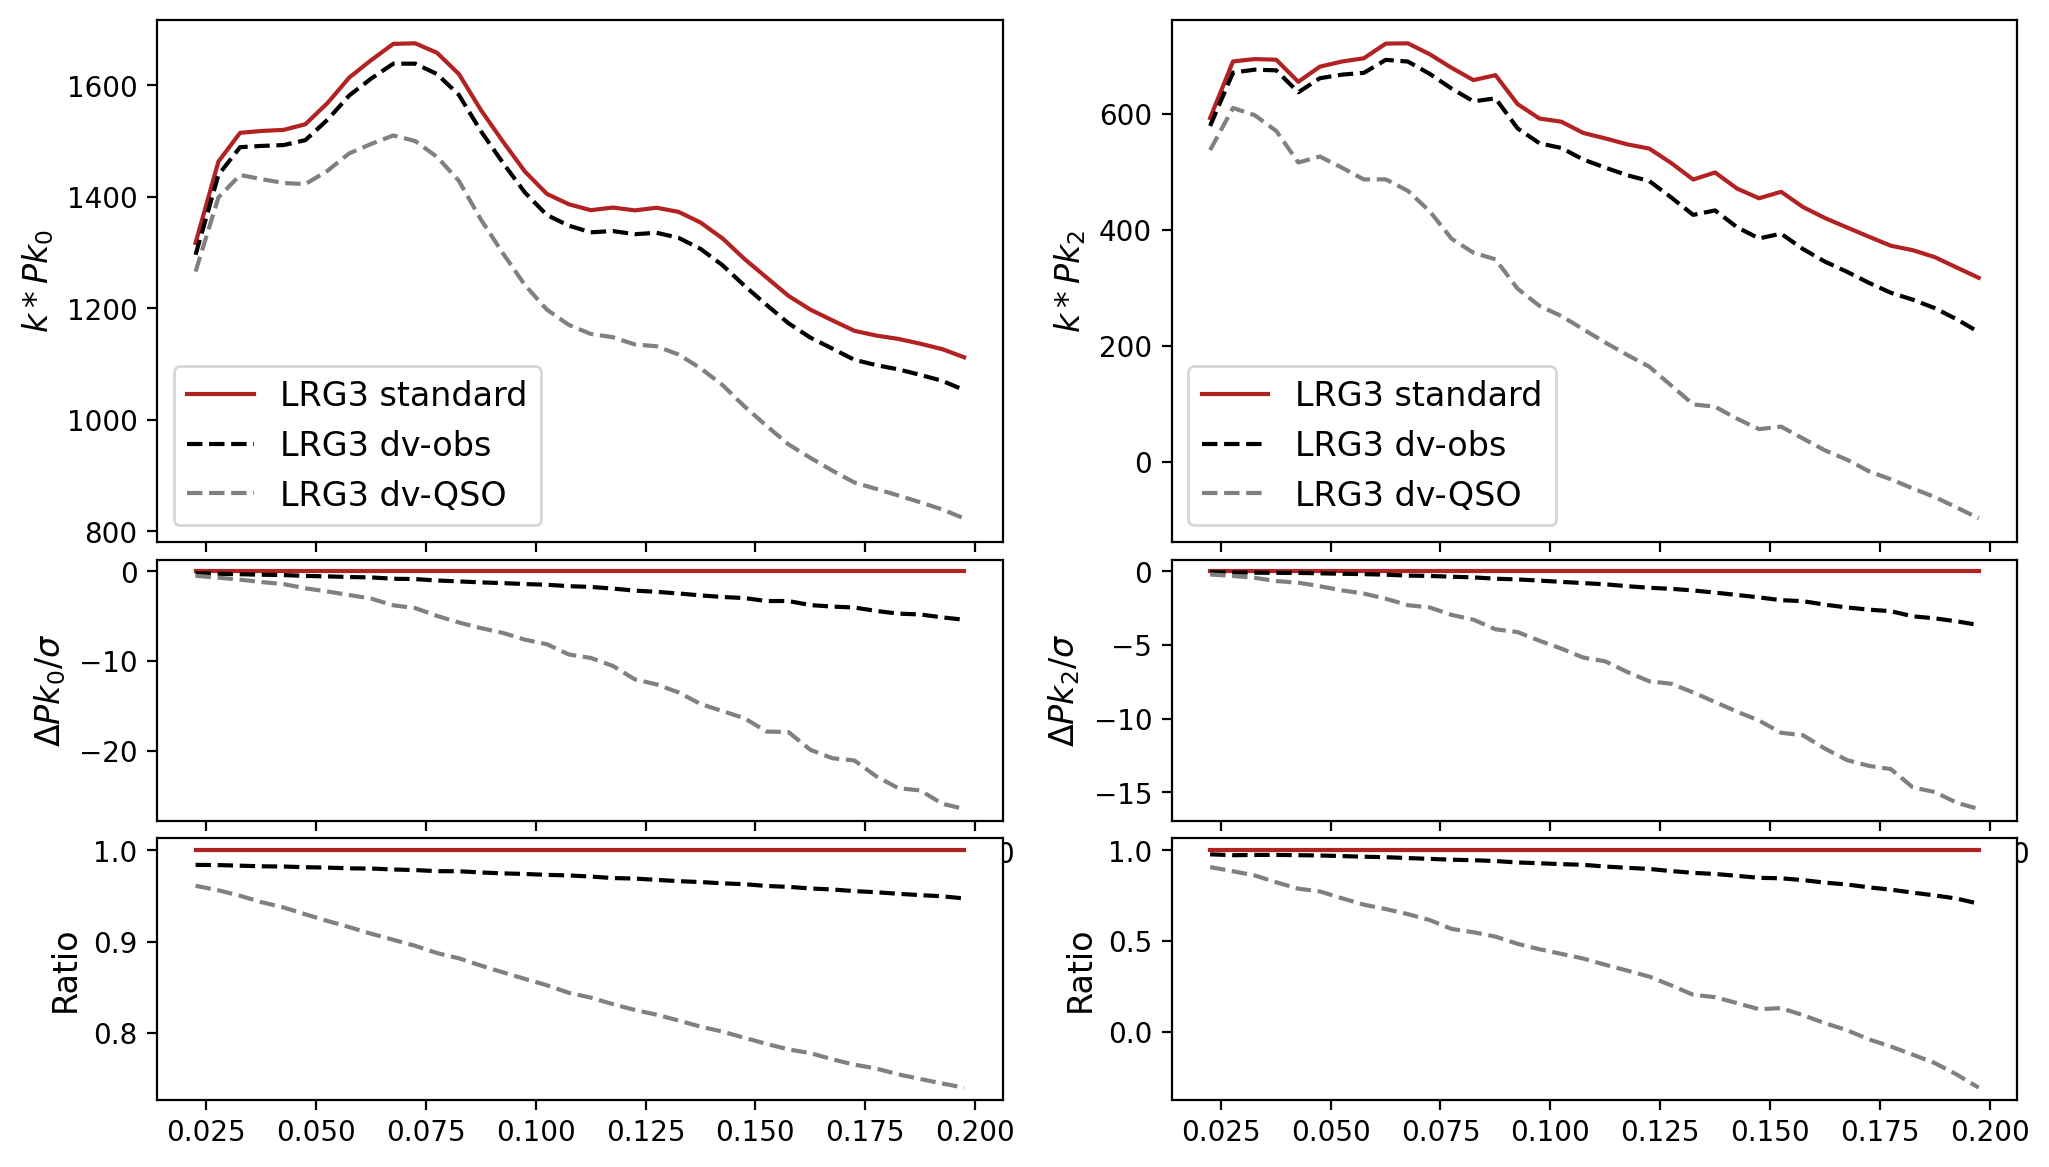

In [74]:
tracer = 'LRG'
(zmin, zmax) = REDSHIFT_LSS_VSMEAR[tracer][2]

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3,2,wspace=0.2,hspace=0.05,left=0.05, right=0.98, top=0.95, bottom=0.05, height_ratios=[2, 1, 1])

for test in ['standard','dv-obs','dv-QSO']:
    option = None
    color = COLOR_TRACERS[tracer][2] if test == 'standard' else 'black'
    ls = '-' if test == 'standard' else '--'
    if test == 'dv-QSO':
        option = 'QSO_test'
        # color = COLOR_TRACERS['QSO'][0]
        color = 'grey'
        sys_model = 'dv-obs'
        ls = '--'
    else:
        sys_model = test
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000", "option":option}
    fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": cov_type, "theory_model": theory_model, "emulator_fn": emulator_fn}
    (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
    k = observable.k[0]
    pk = observable.data
    if sys_model == 'standard':
        pk_standard = pk
        error = [np.sqrt(np.diag(observable.covariance))[:len(k)], np.sqrt(np.diag(observable.covariance))[len(k):2*len(k)]]
    for ill in range(2):
        for j in range(3):
            ax = plt.subplot(gs[j, ill])
            if j == 0:
                ax.plot(k, k*pk[ill], color=color, label=f"{tracer}{index+3} {test}", ls = ls)
                ax.tick_params(labelbottom=False)
                ax.set_ylabel(f'$k*Pk_{ill*2}$')
                ax.legend(loc=3)
            if j == 1:
                ax.plot(k, (pk[ill]-pk_standard[ill])/error[ill], color=color, ls = ls)
                ax.set_ylabel(f'$\Delta Pk_{ill*2}/\sigma$')
            if j == 2:
                ax.plot(k, (pk[ill]/pk_standard[ill]), color=color, ls = ls)
                ax.set_ylabel('Ratio')

In [28]:
results = []
for test in ['standard','dv-obs','dv-QSO']:
    option = None
    color = 'C0' if sys_model == 'standard' else COLOR_TRACERS[tracer][index]
    if test == 'dv-QSO':
        option = 'QSO_test'
        color = COLOR_TRACERS['QSO'][0]
        sys_model = 'dv-obs'
    else:
        sys_model = test
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000", "option":option}
    fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": cov_type, "theory_model": theory_model, "emulator_fn": emulator_fn}
    (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
    profiler = MinuitProfiler(likelihood, seed=42)
    profiles = profiler.maximize()
    print(-2*likelihood(**profiles.bestfit.choice(input=True)))
    results.append(profiles)

Loading exist EZmocks covariance
/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.8-1.1_k0.02-0.2_rsfDR2.txt
[002510.66] [0/1] 05-07 09:51  Emulator                  INFO     Loading /pscratch/sd/s/shengyu/results/cubic/emulator/emulator_FM_LRG_z0.8-1.1_vel_rscov.npy.
[002510.79] [0/1] 05-07 09:51  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_LRG_z0.8-1.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/

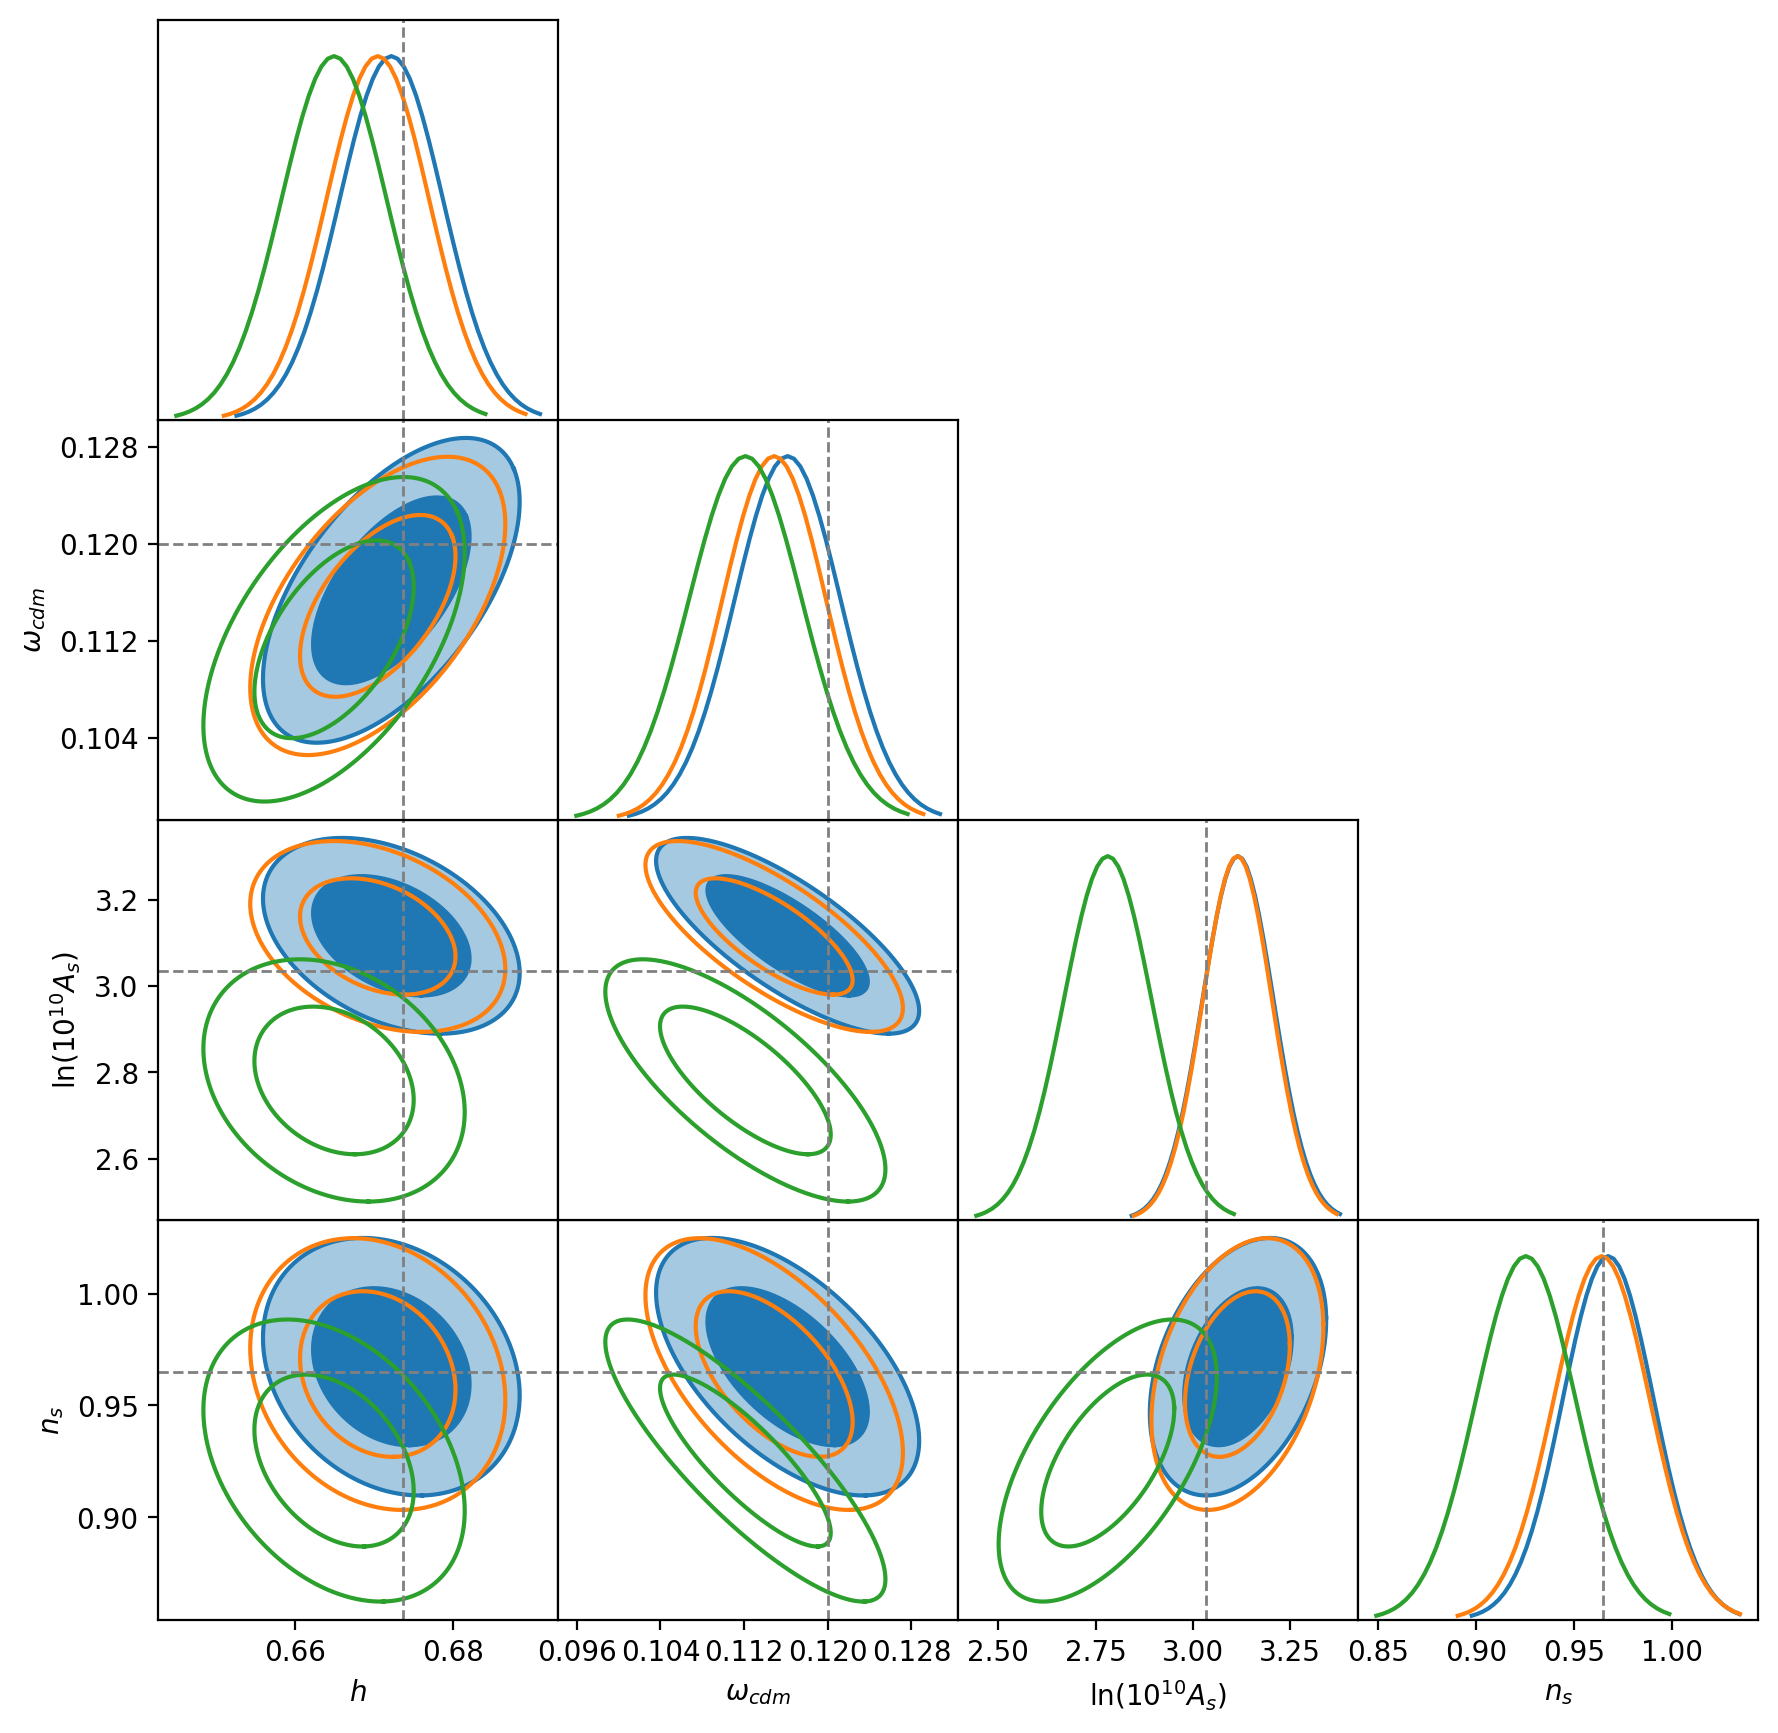

In [ ]:
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
params = ['h', 'omega_cdm', 'logA','n_s']
fig = plotting.plot_triangle_contours(results, params=params, filled=True, truths=set_true_values(fit, params))

In [16]:
results = []
for test in ['dv-obs']:
    option = None
    if test == 'dv-QSO':
        option = 'QSO_test'
        color = COLOR_TRACERS['QSO'][0]
        sys_model = 'dv-obs'
    else:
        sys_model = test
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000", "option":option}
    fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": cov_type, "theory_model": theory_model, "emulator_fn": emulator_fn}
    (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
    nwalkers = 64
    iterations = 30001 # save every 300 iterations
    sampler = EmceeSampler(likelihood, seed=42, nwalkers=nwalkers, save_fn = f'./QSO_test/chain_LRG3_{test}.npy')
    sampler.run(check={'max_eigen_gr': 0.02}, max_iterations = iterations) # save every 300 iterations

Loading exist EZmocks covariance
/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.8-1.1_k0.02-0.2_rsfDR2.txt
[003679.73] [0/1] 05-08 02:24  Emulator                  INFO     Loading /pscratch/sd/s/shengyu/results/cubic/emulator/emulator_FM_LRG_z0.8-1.1_vel_rscov.npy.


[003679.87] [0/1] 05-08 02:24  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_LRG_z0.8-1.1_dv-obs.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_LRG_z0.8-1.1_dv-obs.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_LRG_z0.8-1.1_dv-obs.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph020/mpspk/pkpoles_LRG_z0.8-1.1_dv-obs.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.8-1.1/AbacusSummit_base_c000_ph012/mpspk/pkpoles_LRG_z0.8-1.1_dv-obs.npy].
[003680.07] [0/1] 05-08 02:24  EmceeSampler              INFO     

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samples/diagnostics.py:291: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


[003686.89] [0/1] 05-08 02:24  Diagnostics               INFO     - effective sample size = (150 iterations / integrated autocorrelation time) is nan.
[003686.89] [0/1] 05-08 02:24  Diagnostics               INFO     - current mean acceptance rate is 0.143.
[003691.49] [0/1] 05-08 02:24  Chain                     INFO     Saving ./QSO_test/chain_LRG3_dv-obs.npy.
[003691.50] [0/1] 05-08 02:24  EmceeSampler              INFO     Diagnostics:
[003691.55] [0/1] 05-08 02:24  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.674; not < 0.02.
[003691.60] [0/1] 05-08 02:24  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.114.
[003691.78] [0/1] 05-08 02:24  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.24.
[003691.80] [0/1] 05-08 02:24  Diagnostics               INFO     - max Geweke is 0.202.
[003691.81] [0/1] 05-08 02:24  Diagnostics               INFO     - Geweke p-value is 0.0559.
[003692.10] [0/1] 05-08 02:24  Diag

[004518.30] [0/1] 05-08 02:38  Chain                     INFO     Loading ./QSO_test/chain_LRG3_standard.npy.


[004518.40] [0/1] 05-08 02:38  Chain                     INFO     Loading ./QSO_test/chain_LRG3_dv-obs.npy.
[004518.49] [0/1] 05-08 02:38  Chain                     INFO     Loading ./QSO_test/chain_LRG3_dv-QSO.npy.
Removed no burn in
Removed no burn in
Removed no burn in


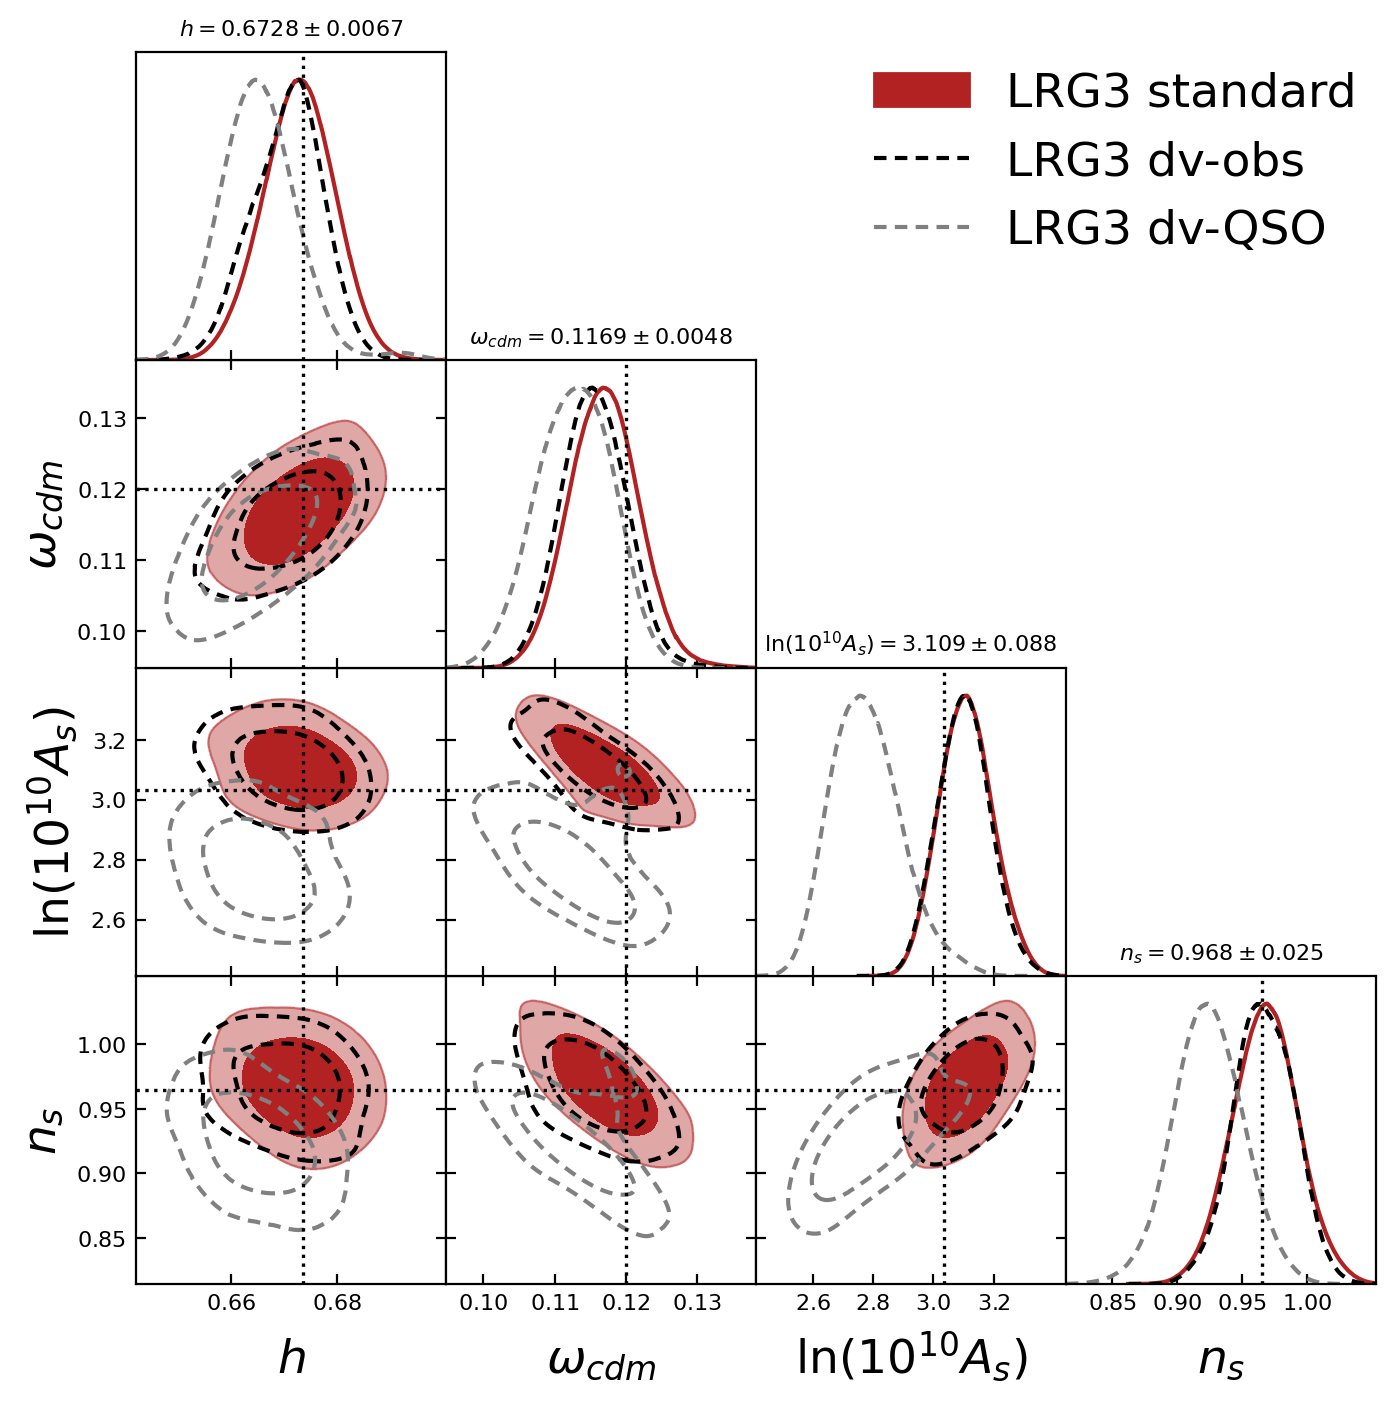

In [18]:
burnin = 0.5
slice_step = 3500

chains   = []
params = ['h', 'omega_cdm', 'logA','n_s']
for test in ['standard','dv-obs','dv-QSO']:
    chain_fn = f'./QSO_test/chain_LRG3_{test}.npy'
    chains.append(Chain.load(chain_fn).remove_burnin(burnin)[::slice_step])

g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
# g.settings.fig_width_inch= 16
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.figure_legend_frame = False
labels  = [f'{tracer}3 standard', f'{tracer}3 dv-obs', f'{tracer}3 dv-QSO']
plotting.plot_triangle(chains, title_limit=1, filled = True, 
                       params = params,
                       legend_labels = labels, legend_loc= 'upper right',
                       contour_lws = 1.5, contour_colors = [COLOR_TRACERS['LRG'][2], 'black', 'grey'],contour_ls = ['-', '--', '--'],
                        # param_limits=param_limits, 
                        smoothed=True, show=False, g=g)
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
true_values     = set_true_values(fit, params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)

In [ ]:
burnin = 0.5
slice_step = 3500
chains   = []
params = ['h', 'omega_cdm', 'logA','n_s']
for test in ['standard','dv-obs','dv-QSO']:
    chain_fn = f'./QSO_test/chain_LRG3_{test}.npy'
    chains.append(Chain.load(chain_fn).remove_burnin(burnin)[::slice_step])

g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
# g.settings.fig_width_inch= 16
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.figure_legend_frame = False
labels  = [f'{tracer}3 standard', f'{tracer}3 dv-obs', f'{tracer}3 dv-QSO']
plotting.plot_triangle(chains, title_limit=1, filled = True, 
                       params = params,
                       legend_labels = labels, legend_loc= 'upper right',
                       contour_lws = 1.5, contour_colors = [COLOR_TRACERS['LRG'][2], 'black', 'grey'],contour_ls = ['-', '--', '--'],
                        # param_limits=param_limits, 
                        smoothed=True, show=False, g=g)
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
true_values     = set_true_values(fit, params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)